In [1]:
print('importing packages...')

importing packages...


In [2]:
import time
tot_tic = time.time()
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import sys
import pandas as pd
import cantera as ct
import numpy as np
import os
from scipy import interpolate
import plotly.graph_objects as go

In [3]:
########## System conditions ##########
lengths = [36,13,133,97] # inches
diameters = [20.5,15.5,10.5,8] # inches


SR = 2.161
exhaust_gas_q = 960 # total volumetric flow rate (L/min)
injection_loc = 55 # inches, see files\rainbow_ports.txt for list of port locations
injectant = 'CHCL3' # injected species, must be in quotations and match name in mechanism file
injectant_conc = 35e-6 # injected species concentration in furnace @ injection point (mol fraction)
output_folder = 'Output/CHCL3' # script will auto-generate the folder

########## Mechanism ##########
#mechanism = 'NCSU_PFASmech1.0.yaml' # mechanism file, irrelevant if 'yaml' = False
mechanism = 'rei_chloro.yaml' # mechanism file, irrelevant if 'yaml' = False
yaml = True # if False, below chemkin format files will be converted to a Cantera friendly yaml file
kinetics = 'NCSU_PFASmech1.0_Kinetics.inp'
thermo = 'NCSU_PFASmech1.0_Thermo.dat'
output = 'new_mech_file.yaml' # must have .yaml extension

########## Temperature fitting ##########
measured_temps = [927,864,819,753,711,655,501,449,399,364] # °C
measured_temps_locs = [18,55,79,103,127,151,201,225,249,273] # inches
ff = 0.9 # "fudge factor" for flame temp because Cantera's solution is adiabatic
spline = True # fit using scipy.interpolate.UnivariateSpline (True) or numpy.polyfit (False)
k = 3 # spline degree
s = None # spline smoothing factor, see scipy documentation for guidance
pdeg = 4 # polynomial degree, only appliciable if 'spline' is set to False

########## Path diagram ##########
path_res_time = 0.001 # seconds, precision will be limited by grid resolution settings
path_element = 'Cl' # case sensitive
path_species = 'all' # 'all' or individual species name to only display fluxes connected to that species
path_threshold = 0.1 # kmol/m3/sec
path_details = False # or True

########## Grid resolution ##########
post_injection_res_time_step = 1e-3 # residence time grid size (seconds)
post_injection_duration = 1e-1 # seconds
elsewhere_res_time_step = 1e-2 # residence time grid size (seconds)

########## Additional settings ##########
run_with_dialog = False # Running with dialog may be best for public distributions
print_info_every = 100 # print simulation info every n time steps
atol = 1e-15 # absolute error tolerance for reactor equations solver
rtol = 1e-9 # relative error tolerance for reactor equations solver
it0 = True # generate output with pre-injection data trimmed off (True) or not trimmed (False)
concentrations_interactive_plot_cutoff = 1e-7 # mol fraction
rates_interactive_plot_cutoff = 1e-8 # mol/m3/s
save_rates_solution = False # Generating the net rates excel spreadsheet adds a lot of wall time
individual_plots = False # Generating individual species concentration plots adds a lot of wall time
major_species_cutoff = 1e-6 # mol fraction
minor_species_cutoff = 1e-15 # mol fraction

In [4]:

if os.path.exists(output_folder) == False: #check if output folder exists
    os.makedirs(output_folder) #create output folder if it doesn't exist

file = open(f'{output_folder}/log.txt', 'w') #create log file
file.close() #close log file

def myprint(txt): #print to console and log file
    print(txt, file=open(f'{output_folder}/log.txt', 'a'))
    print(txt)
    file.close()
    
def myinput(txt): #input to console and log file
    inp = input(txt)
    print(txt+inp, file=open(f'{output_folder}/log.txt', 'a'))
    file.close()
    return inp

In [5]:
# restart function only works for executable, not in python interpreter
def restart_main():
    executable = sys.executable
    executable_filename = os.path.split(executable)[1]
    os.execv(executable, sys.argv)

while os.system('dot -V') == 1:
    myprint('graphviz must be installed on your PATH to generate reaction pathway diagrams')
    time.sleep(1)
    myinput('press enter to launch graphviz installer')
    
    path_to_file = 'files/'
    exe = 'graphviz-install.exe'
    cur_dir = os.getcwd()
    os.chdir(path_to_file) # change folder
    os.system(f'{exe}')
    os.chdir(cur_dir) # go back
    
    myprint('graphviz installed -> restarting PFRTP run...')
    
    restart_main()

In [6]:
if yaml == False and os.path.exists(output) == True:
    myprint('output mechanism yaml file already exists -> no mechanism file format conversion necessary...')
    mechanism = output
elif yaml == False:
    myprint('converting chemkin mechanism files to yaml file...')
    args = f' python -m cantera.ck2yaml --input={kinetics} --thermo={thermo} --output={output} --permissive'
    os.system(args)
    mechanism = output
else:
    ...

In [7]:
myprint(' ')
gri_names = list(ct.Solution('files/gri3.0.yaml').species_names)
mech_names = list(ct.Solution(mechanism).species_names)
notin = []
for species in gri_names:
    if species in mech_names:
        ...
    else:
        notin.append(species)

if notin:
    myprint('WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. '+
            'The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism.'+
            ' GRI-Mech 3.0 contains '+str(len(notin))+' species that were not identified in the input mechanism: '+" ".join(notin))
    myprint('You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.')
    myprint('The GRI-Mech 3.0 file used by PFRTP can be found at files')
    myprint(' ')
    myprint(' ')
else:
    ...

In [8]:
# Burn a flame and save the off-gas state as a yaml file.

ER = SR**-1
fname = 'files/flames/'+'flame_'+str(SR)+'.yaml'
if os.path.exists(fname) == False:
    myprint('flame solution does not exist for input SR -> solving flame...')
    To = 300
    Po = 101325
    gas = ct.Solution('files/gri3.0.yaml')
    gas.set_equivalence_ratio(ER, "CH4", {"O2": 1.0, "N2": 3.76})
    gas.TP = To, Po
    flame = ct.FreeFlame(gas)
    flame.solve(auto=True, loglevel=1)
    flame.gas.write_yaml(fname)
    myprint('flame solved -> creating polynomial fit for temperature profile...')
else:
    myprint('flame solution exists for input SR -> fitting temperature profile...')

flame solution exists for input SR -> fitting temperature profile...


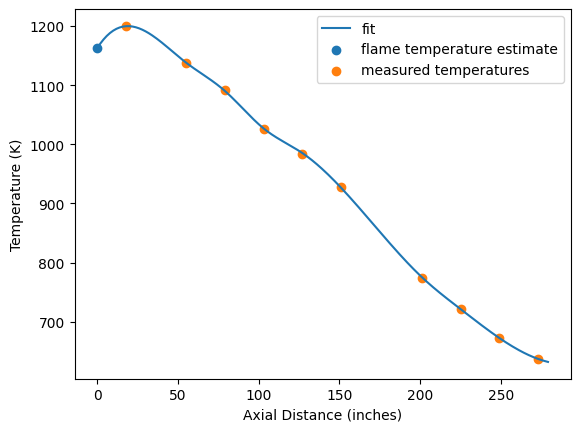

In [9]:
# Convert user input to model-friendly input

flame_temp_estimate = ct.Solution(fname).T*ff

if 0 in measured_temps_locs:
    measured_temps_new = [x+273.15 for x in measured_temps]
    measured_temps_locs_new = measured_temps_locs
else:
    measured_temps_new = [flame_temp_estimate]+[x+273.15 for x in measured_temps]
    measured_temps_locs_new = [0] + measured_temps_locs

# fit temps to axial length (a reasonable simplification)
xf = range(sum(lengths)+1)
if spline == True:
    spl = interpolate.UnivariateSpline(measured_temps_locs_new, measured_temps_new, k=k, s=s)
    T_fit = spl(xf)
else:
    z = np.polyfit(measured_temps_locs_new, measured_temps_new, pdeg)
    f = np.poly1d(z)
    T_fit = np.round(f(xf), 0) #### don't need round anymore?

# Plot fit
plt.plot(xf,T_fit,label='fit')
if 0 in measured_temps_locs:
    plt.scatter(measured_temps_locs,measured_temps_new,label='measured')
else:
    plt.scatter(0,flame_temp_estimate,label='flame temperature estimate')
    plt.scatter(measured_temps_locs,measured_temps_new[1:],label='measured temperatures')
plt.ylabel('Temperature (K)')
plt.xlabel('Axial Distance (inches)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_axial_distance.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show()

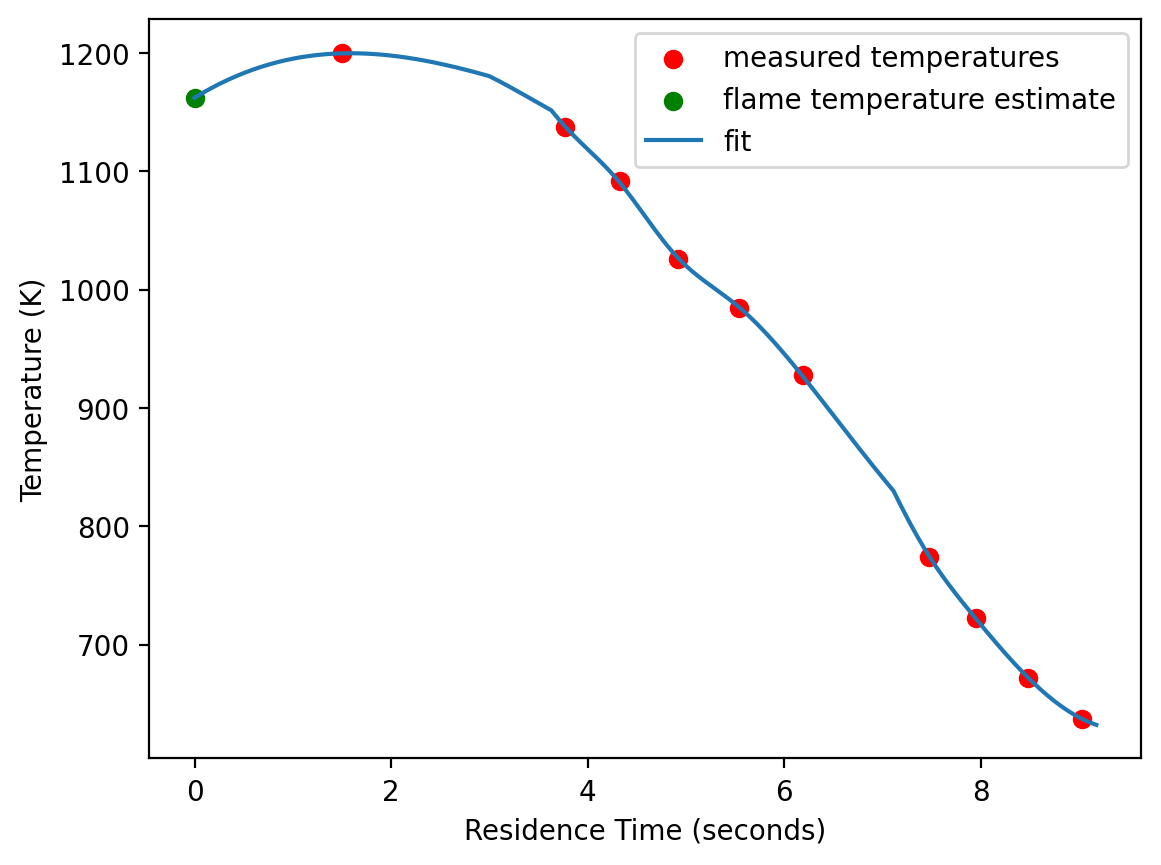

In [27]:
# Convert axial length fit to residence time fit based on slice volumes, temperatures, and flow rates

# start by making list of slice volumes, slices have 1-inch lengths
v = [0]
for l,d in zip(lengths,diameters):
    slice_lengths = np.zeros(l) + 1 # a list of "1"s the length of the nth section
    slice_vols = slice_lengths * np.pi * d**2 / 4 # a list of the corresponding volumes
    v.extend(list(slice_vols)) # extend the total list of volumes
    
Q = exhaust_gas_q * T_fit / 293.15 # list of T-corrected flows through each volume (L/min) based on ideal gas law
res_t = 60*np.array(v)/(61*Q) # list of slice res times (seconds), divided by 61 to convert L/min to in^3/min
t_cum = np.cumsum(res_t) # a list of slice cumulative res times (seconds)

# Plot fit
if 0 in measured_temps_locs:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new,c='red',label='measured')
else:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new[1:],c='red',label='measured temperatures')
    plt.scatter(t_cum[0],measured_temps_new[0],c="green",label='flame temperature estimate')
plt.plot(t_cum,T_fit,label='fit')
plt.ylabel('Temperature (K)')
plt.xlabel('Residence Time (seconds)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_res_time.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show()

In [11]:
myprint('plots of temperature profile fit saved to output folder')
if run_with_dialog == True:
    time.sleep(2)
    myinput('if satisfied with fit, press enter to run PFR simulation')
else:
    ...
myprint('PFR simulation running...')

plots of temperature profile fit saved to output folder
PFR simulation running...


In [12]:
# Interpolate res time fit to user-defined resolution
i_t = t_cum[np.round(injection_loc,0)]

tgap1 = np.zeros(int(i_t/elsewhere_res_time_step)) + elsewhere_res_time_step

tinj = np.zeros(int(post_injection_duration/post_injection_res_time_step)) + post_injection_res_time_step

tgap2 = np.zeros(int((t_cum[-1]-i_t-post_injection_duration)/elsewhere_res_time_step)) + elsewhere_res_time_step

tnew = np.concatenate(([0],tgap1,[i_t-sum(tgap1)],tinj,tgap2))
f = interpolate.interp1d(t_cum, T_fit) 
Tnew = f(np.cumsum(tnew))

In [13]:
# define a function to map gri flame-gas species concentrations to mechanism species concentrations

def gri_to_mech(mech):
    gri_species = list(ct.Solution('files/gri3.0.yaml').species_names)
    mech_species = list(ct.Solution(mechanism).species_names)
    gri_c = list(ct.Solution(fname).X)
    mech_c = list(ct.Solution(mechanism).X)
    for species in gri_species:
        if species in mech_species:
            mech_c[mech_species.index(species)] = gri_c[gri_species.index(species)]
        else:
            ...
    return mech_c

In [14]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_index = ct.Solution(mechanism).species_index(injectant)

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            concentrations[injectant_index] = injectant_conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [ ]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_index = ct.Solution(mechanism).species_index(injectant)

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            concentrations[injectant_index] = injectant_conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [ ]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_index = ct.Solution(mechanism).species_index(injectant)

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            concentrations[injectant_index] = injectant_conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [15]:
# run the simulation
tic = time.time()
sim_data, nrp = sim(Tnew,tnew)
toc = time.time()
myprint(
    f'PFR simulation completed with wall time of: {str(round(toc - tic, 2))} seconds'
)

timestep: 100   total residence time (s): 0.99   temperature (K): 1195.02   elapsed wall time(s): 2.18
timestep: 200   total residence time (s): 1.99   temperature (K): 1197.92   elapsed wall time(s): 3.44
timestep: 300   total residence time (s): 2.99   temperature (K): 1180.69   elapsed wall time(s): 4.84
timestep: 400   total residence time (s): 3.7888   temperature (K): 1136.24   elapsed wall time(s): 6.52
timestep: 500   total residence time (s): 4.0868   temperature (K): 1111.81   elapsed wall time(s): 8.41
timestep: 600   total residence time (s): 5.0868   temperature (K): 1013.95   elapsed wall time(s): 10.31
timestep: 700   total residence time (s): 6.0868   temperature (K): 937.26   elapsed wall time(s): 11.92
timestep: 800   total residence time (s): 7.0868   temperature (K): 832.48   elapsed wall time(s): 13.36
timestep: 900   total residence time (s): 8.0868   temperature (K): 708.28   elapsed wall time(s): 14.84
timestep: 1000   total residence time (s): 9.0868   temperat

In [16]:
# generate excel files
myprint(' ')
if run_with_dialog == True:
    time.sleep(2)
    myinput('press enter to generate output')
else:
    ...
myprint('generating and saving output to output folder...')

 
generating and saving output to output folder...


In [17]:
cantera_species = ct.Solution(mechanism).species_names
tplot = np.concatenate(([0],np.cumsum(tinj),np.cumsum(tgap2)+sum(tinj)))[:-1]
Tplot = Tnew[len(tnew)-len(sim_data):]

sim_data_new = list(np.array(sim_data).T)
sim_data_new.insert(0,Tplot)
sim_data_new.insert(0,tplot)
sol = np.array(sim_data_new).T
columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_species
pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_concentrations.xlsx")

In [18]:
eff_c = [] # effluent concentrations

for species in np.arange(len(cantera_species)):
    name = cantera_species[species]
    eff_c.append([name, np.array(sim_data)[:,species][-1]])

c = np.array(eff_c)
c_sorted = c[(c[:,1]).astype(float).argsort()[::-1]]
df = pd.DataFrame(c_sorted, columns=['Species','Effluent Concentration (mol fraction)'])
df.to_excel(output_folder+"\\solution_effluent_concentrations.xlsx")

In [19]:
cantera_reactions = list(ct.Solution(mechanism).reaction_equations())
if save_rates_solution == False:
    ...
else:
    nrp_new = list(np.array(nrp).T)
    nrp_new.insert(0,Tnew[len(tnew)-len(nrp):])
    nrp_new.insert(0,tplot)
    sol = np.array(nrp_new).T
    columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_reactions
    pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_reactions.xlsx")

In [20]:
data = np.array(sim_data).T
fig = go.Figure()
for i in np.arange(len(cantera_species)):
    if max(data[i])<concentrations_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_species[i]))
fig.update_yaxes(title_text='Concentration (mol fraction)',type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_concentrations.html")

In [21]:
data = np.array(nrp).T
fig = go.Figure()
for i in np.arange(len(cantera_reactions)):
    if max(data[i])<rates_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_reactions[i]))
    
ylabel='Net Rate of Progress (kmol/m3/s)'
fig.update_yaxes(title_text=ylabel,type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_net_rates.html")

In [22]:
# generate figures and excel files
# organize them based on maximum concentration across all slices

if individual_plots == True:
    if os.path.exists(output_folder+r"\\individual_major_species") == False:
        os.makedirs(output_folder+r"\\individual_major_species")
    if os.path.exists(output_folder+r"\\individual_minor_species") == False:
        os.makedirs(output_folder+r"\\individual_minor_species")
    neg_species = [] # negligible species
    eff_c = [] # effluent concentrations

    for species in np.arange(len(cantera_species)):
        name = cantera_species[species]
        eff_c.append([name, np.array(sim_data)[:,species][-1]])

        plt.plot(tplot,np.array(sim_data)[:,species])
        plt.xlabel('Residence time (seconds)')
        plt.ylabel('Concentration (mol fraction)')
        plt.title(name, fontsize=20,fontweight='bold')
        plt.yscale('log')
        if np.max(np.array(sim_data)[:,species]) > major_species_cutoff:
            plt.savefig(output_folder+'\\individual_major_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        elif np.max(np.array(sim_data)[:,species]) > minor_species_cutoff:
            plt.savefig(output_folder+'\\individual_minor_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        else:
            neg_species.append([name, np.max(np.array(sim_data)[:,species])])
        plt.close();

    df = pd.DataFrame(neg_species, columns=['Species', 'Maximum Concentration (mol fraction)'])
    df.to_excel(output_folder+"\\negligible_species.xlsx")
    
else:
    ...

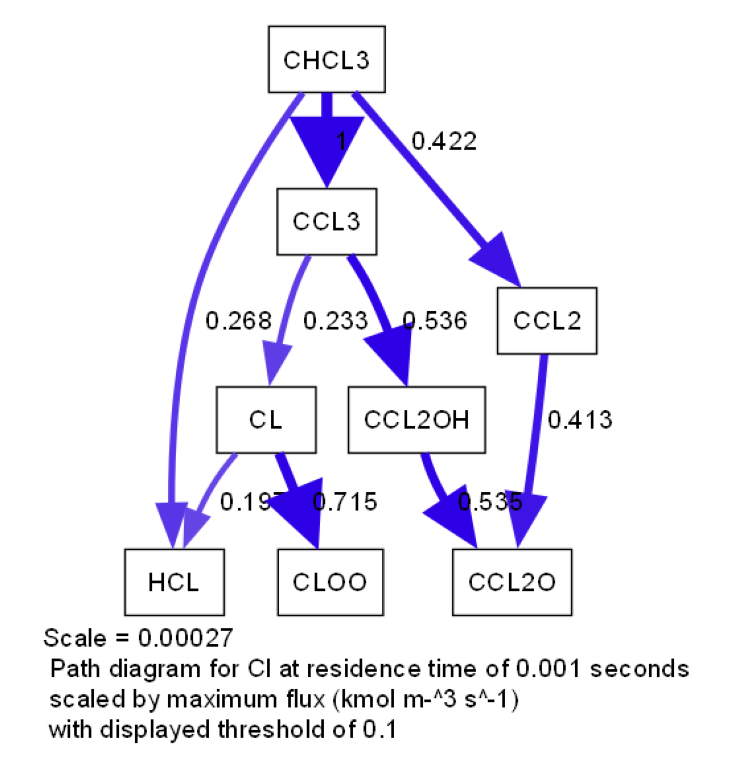

In [23]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)
retry = 'y'

while retry == 'y':
    plot_step = np.abs(tplot - path_res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, path_element)
    diagram.threshold = path_threshold
    diagram.dot_options='node[shape="box"]'
    title = (
        (
            f'Path diagram for {path_element} at residence time of {str(path_res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(path_threshold)
    diagram.title = title
    diagram.show_details = path_details
    diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=100')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    if run_with_dialog == True:
        retry = myinput('path diagram saved to output folder...generate new path diagram? (y/n): ')
    else:
        retry = 'n'
    if retry == 'y':
        path_res_time = float(myinput('type path diagram residence time (in seconds) and press enter: '))
        path_element = myinput('type path diagram element symbol and press enter: ')
        path_species = myinput('type path diagram species and press enter (all/individual species name): ')
        path_threshold = float(myinput('type path diagram threshold and press enter: '))
        path_details = input('show path details? (y/n) and press enter: ').lower().strip() == 'y'
    else:
        ...

In [24]:
tot_toc = time.time()
myprint(
    f'PFR run completed with total wall time of: {str(round(tot_toc - tot_tic, 2))} seconds'
)
time.sleep(3)

PFR run completed with total wall time of: 32.68 seconds


In [25]:
from ipywidgets import widgets, interact
from ipywidgets import SelectionSlider

In [26]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)

t_min = 0.0
t_max = post_injection_duration #max(tplot)
t_step = post_injection_res_time_step #elsewhere_res_time_step

thresh_min = 0.0
thresh_max = 1.0
thresh_step = 1e-2

def format_float(num):
    return np.format_float_positional(num, trim='-')

@interact(
    res_time=SelectionSlider(value=t_min+t_step,
                             options=[("%g"%i,i) for i in np.arange(t_min,t_max,t_step)]),
    threshold=SelectionSlider(value=thresh_min+thresh_step,
                              options=[("%g"%i,i) for i in np.arange(thresh_min,thresh_max,thresh_step)]),
    details=widgets.ToggleButton(),
    species=widgets.Dropdown(
        options=gas.element_names,
        value=path_element,
        description="Element",
        disabled=False,
    ),
)
def plot_reaction_path_diagrams(res_time, threshold, details, species):
    plot_step = np.abs(tplot - res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, species)
    diagram.threshold = threshold
    diagram.dot_options='node[shape="box"]'
    diagram.show_details = details
    diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    #diagram.display_only(gas.species_index('HOCL'))
    title = (
        (
            f'Path diagram for {species} at residence time of {str(res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(threshold)
    diagram.title = title
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=300')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

interactive(children=(SelectionSlider(description='res_time', index=1, options=(('0', 0.0), ('0.001', 0.001), …